In [1]:
import pyart
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
from pyproj import Proj, CRS, Transformer


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Date of the data
year = '2025'
month = '03'
day = '13'

# The path to the data directory
# The data is stored in the following directory structure
# /mnt/gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y2025/M03/D13/
# The year, month and day are used to construct the path
data='/gws/nopw/j04/tone_ico_gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y'+year+'/M'+month+'/D'+day+'/'

# The name of the file
# The file name is constructed from the date and the radar name
# The radar name is tone-ico_doppler_scanning_cloud_radar
# The scan name is tone-ico_terrace_wind_az_0_360_el_18_18_250313_113959_P05_PPI
# The data type is '.LV1.NC' which indicates that it is the Level 1 (Moments) in netCDF format
file=data+'tone-ico_doppler_scanning_cloud_radar_tone-ico_terrace_wind_az_0_360_el_18_18_250313_113959_P05_PPI.LV1.NC'

# Read the data
import xarray as xr
ds = xr.open_dataset(file)
print(ds)


<xarray.Dataset> Size: 2MB
Dimensions:      (TAlt: 93, HAlt: 93, Chirp: 4, Time: 107, C1Range: 10,
                  C2Range: 67, C3Range: 83, C4Range: 90)
Coordinates:
  * Time         (Time) uint32 428B 763558799 763558802 ... 763559041 763559043
  * C1Range      (C1Range) float32 40B 59.62 119.2 178.9 ... 477.0 536.6 596.2
  * C2Range      (C2Range) float32 268B 655.8 715.5 ... 4.531e+03 4.591e+03
  * C3Range      (C3Range) float32 332B 4.651e+03 4.71e+03 ... 9.48e+03 9.54e+03
  * C4Range      (C4Range) float32 360B 9.659e+03 9.718e+03 ... 1.497e+04
Dimensions without coordinates: TAlt, HAlt, Chirp
Data variables: (12/113)
    ProgNo       int32 4B ...
    ModelNo      int32 4B ...
    Freq         float32 4B ...
    AntSep       float32 4B ...
    AntDia       float32 4B ...
    AntG         float32 4B ...
    ...           ...
    C4PhiDP      (Time, C4Range) float32 39kB ...
    C4ZE45       (Time, C4Range) float32 39kB ...
    C4SLDR       (Time, C4Range) float32 39kB ...
    C4

-72.01041
2.5452983


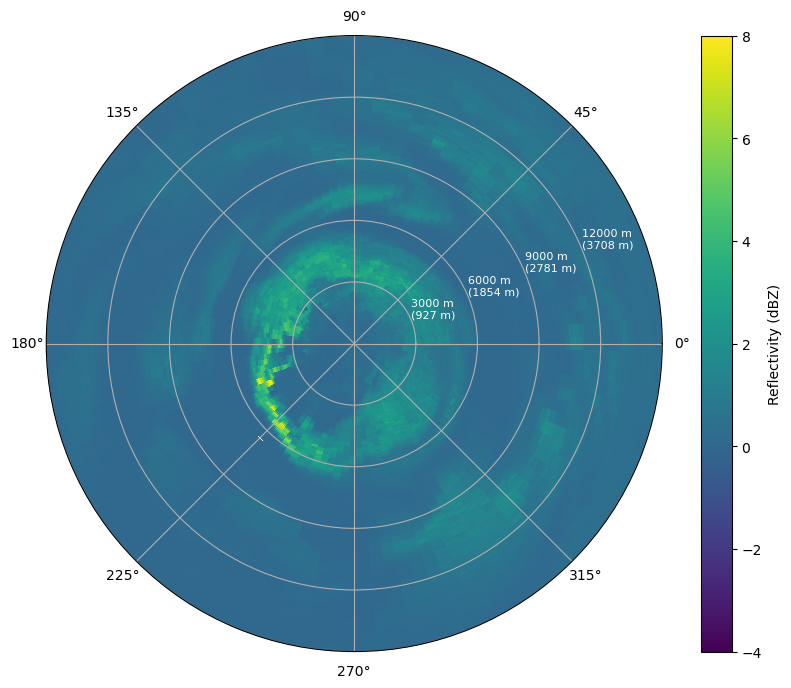

In [3]:
# ...existing code...
trollLat = ds['GPSLat'].values
trollLon = ds['GPSLon'].values

print(trollLat)
print(trollLon)

# Stack all CZE variables along the range dimension
cze_vars = ['C1ZE45', 'C2ZE45', 'C3ZE45', 'C4ZE45']
data_list = [ds[var].values for var in cze_vars]
range_list = [ds[var.replace('ZE45', 'Range')].values for var in cze_vars]

# Concatenate data and ranges
data_stacked = np.concatenate(data_list, axis=1)  # shape: (n_az, total_range)
ranges_stacked = np.concatenate(range_list)       # shape: (total_range,)

# Set all values below -30 to NaN
data_stacked[data_stacked < -30] = np.nan

# Generate synthetic azimuths (assuming evenly spaced)
n_az = ds['Time'].size
azimuths = np.linspace(0, 2 * np.pi, n_az, endpoint=False)

# Create 2D grids for polar plot
azimuths_2d, ranges_2d = np.meshgrid(azimuths, ranges_stacked, indexing='ij')

# Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
pcm = ax.pcolormesh(
    azimuths_2d, ranges_2d, data_stacked,
    cmap='viridis', vmin=-4, vmax=8
)
plt.colorbar(pcm, ax=ax, label='Reflectivity (dBZ)')

# Add altitude to range ring labels (assuming elevation angle is 18 deg)
el_deg = ds.variables['Elv'][0]
el_rad = np.deg2rad(el_deg)
max_range = np.nanmax(ranges_stacked)
range_ticks = np.arange(3000, max_range + 3000, 3000)
ax.set_yticks(range_ticks)
altitude_labels = [f"{int(r)} m\n({int(r*np.sin(el_rad))} m)" for r in range_ticks]
ax.set_yticklabels(altitude_labels, fontsize=8, color='white')


#ax.set_title('Radial PPI-like plot of all CZE stacked\nRange (m) with Altitude (m) in parentheses')
plt.show()
# ...existing code...

In [5]:
X = ranges_2d * np.cos(azimuths_2d)   # Cartesian x
Y = ranges_2d * np.sin(azimuths_2d)   # Cartesian y

crs_centered = CRS.from_proj4(f"+proj=aeqd +lat_0={trollLat} +lon_0={trollLon} +datum=WGS84 +units=m +no_defs")
crs_geo = CRS.from_epsg(4326)  # WGS84 lat/lon

transformer = Transformer.from_crs(crs_centered, crs_geo, always_xy=True)

lon, lat = transformer.transform(X, Y)

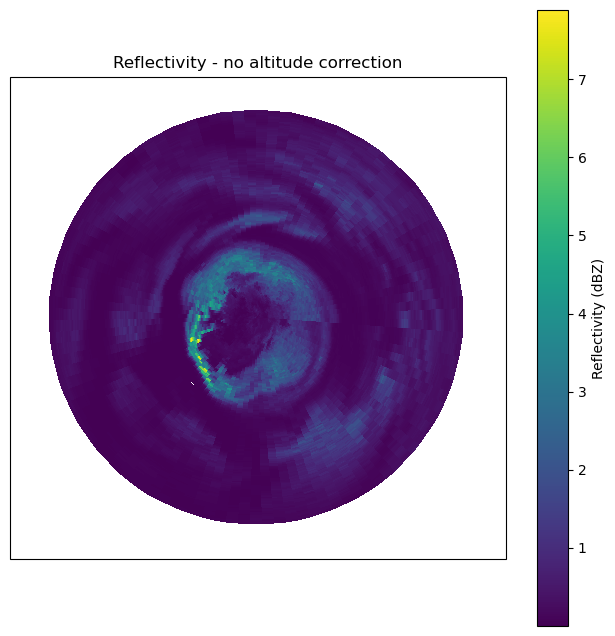

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.set_extent([trollLon-0.5, trollLon+0.5, trollLat-0.15, trollLat+0.15], crs=ccrs.PlateCarree())
ax.coastlines()

cf = ax.pcolormesh(lon, lat, data_stacked, transform=ccrs.PlateCarree(), cmap='viridis')
plt.colorbar(cf, label='Reflectivity (dBZ)')
plt.title("Reflectivity - no altitude correction")

plt.show()

(107, 250)
107
